In [4]:
import mlflow
runs = mlflow.search_runs(experiment_ids=["0"])

In [5]:
runs.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.max_accuracy', 'metrics.aucroc',
       'metrics.wasserstein_score', 'metrics.pmse_score',
       'params.aucroc_synthesizer', 'params.aucroc_epsilon', 'params.epsilon',
       'params.synthesizer', 'params.wasserstein_epsilon',
       'params.pmse_epsilon', 'params.wasserstein_synthesizer',
       'params.pmse_synthesizer', 'tags.mlflow.source.git.commit',
       'tags.max_accuracy', 'tags.aucroc', 'tags.mlflow.source.type',
       'tags.dataset', 'tags.mlflow.source.name', 'tags.mlflow.user',
       'tags.pmse', 'tags.wasserstein', 'tags.wasserstein_dataset',
       'tags.pmse_dataset', 'tags.mlflow.runName'],
      dtype='object')

In [6]:
from collections import Counter

c = Counter(runs['tags.max_accuracy'])
c.most_common()

[(None, 48),
 ('AdaBoostClassifier', 22),
 ('LogisticRegression', 13),
 ('MLPClassifier', 9),
 ('BaggingClassifier', 5),
 ('GaussianNB', 5)]

In [ ]:
runs[['metrics.wasserstein_score',
      'metrics.pmse_score',
      'params.wasserstein_epsilon', 
      'params.pmse_epsilon', 
      'params.wasserstein_synthesizer', 
      'params.pmse_synthesizer']]

In [ ]:
runs[['metrics.wasserstein_score',
      'params.wasserstein_epsilon', 
      'params.wasserstein_synthesizer',
     'tags.wasserstein_dataset']]

In [62]:
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import conf

color_map = {
    'dpctgan': 'lightcoral',
    'dpgan': 'darkviolet',
    'pategan': 'limegreen',
    'mwem': 'dodgerblue',
    'quail_dpctgan': 'lightcoral',
    'quail_dpgan': 'darkviolet',
    'quail_pategan': 'limegreen',
    'quail_mwem': 'dodgerblue',
    'real_mushroom': 'black'
}
# 'dpctgan': 'lightcoral',
#     'dpgan': 'peru',
#     'pategan': 'orange',
#     'mwem': 'yellowgreen',

def gen_plot_dict(runs, x, y, series, dataset, x_label, y_label):
    """
    Will produce a accuracy-by-epsilon graph from an artifact.json
    file.
    """
    metrics = runs[[x,y,series,dataset]]
    # print(metrics)
    plot_dict = {}
    
    for index, row in metrics.iterrows():
        if row[series] not in plot_dict:
            plot_dict[row[series]] = []
        if row[x] and row[y]:
            plot_dict[row[series]].append((float(row[x]),float(row[y]), row[dataset]))
    
    # print(plot_dict)
    return plot_dict

def gen_scatter_plot(plot_dict, plot_index, title, label_dict):
    colors = ['--r','--b','--g', '--c', '--m', '--y', 'r', 'b', 'g', 'c', 'm', 'y']
    # colors[j+i % len(colors)]
    eps = [0.01, 0.1, 1.0, 10.0, 30.0, 60.0, 90.0]
    plt.figure(figsize=(12,8))
    for i, series in enumerate(plot_dict):
        X = {}
        Y = {}
        points = plot_dict[series]
        points.sort(key=lambda x: x[0])
        for x, y, d in points:
            if d not in X:
                X[d] = []
            if d not in Y:
                Y[d] = []
            if x == 0.0:
                x = eps.pop(0)
            X[d].append(x)
            if label_dict['y_label'] == 'aucroc':
                Y[d].append(1.0-y)
            else:
                Y[d].append(y)
        for j, d in enumerate(X):
            if series:
                if series.split('_')[0] == 'quail':
                    plt.plot(X[d], Y[d], color_map[series], linestyle="--", label = series)
                else:
                    plt.plot(X[d], Y[d], color_map[series], label = series)
    plt.xscale("log")
    plt.legend()
    plt.title(title)
    plt.xlabel(label_dict['x_label'])
    plt.ylabel(label_dict['y_label'])
    plt.xlim([0,100])
    plt.figure(plot_index)
    plt.show()

def make_plots(runs, plots):
    for i, p in enumerate(plots):
        plot_dict = gen_plot_dict(runs, **plots[p])
        gen_scatter_plot(plot_dict, i, p, plots[p])

In [47]:
runs['tags.dataset']

0      mushroom
1      mushroom
2      mushroom
3      mushroom
4      mushroom
         ...   
97         None
98         None
99         None
100        None
101    mushroom
Name: tags.dataset, Length: 102, dtype: object

<ipython-input-62-2702afb19fc1>:75: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,100])


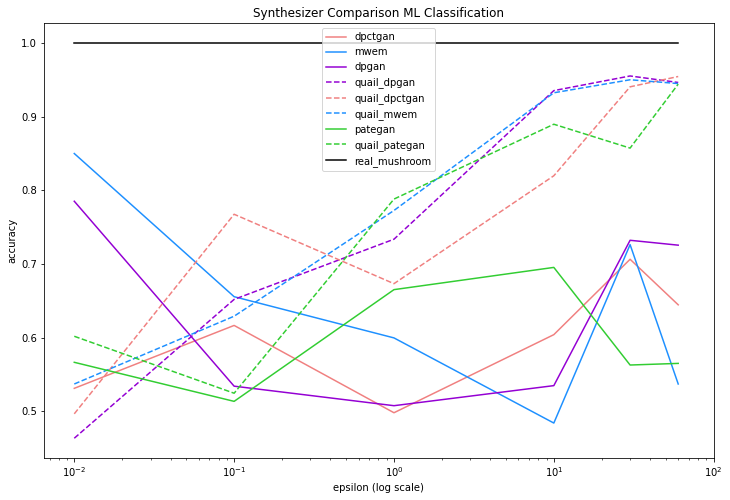

<Figure size 432x288 with 0 Axes>

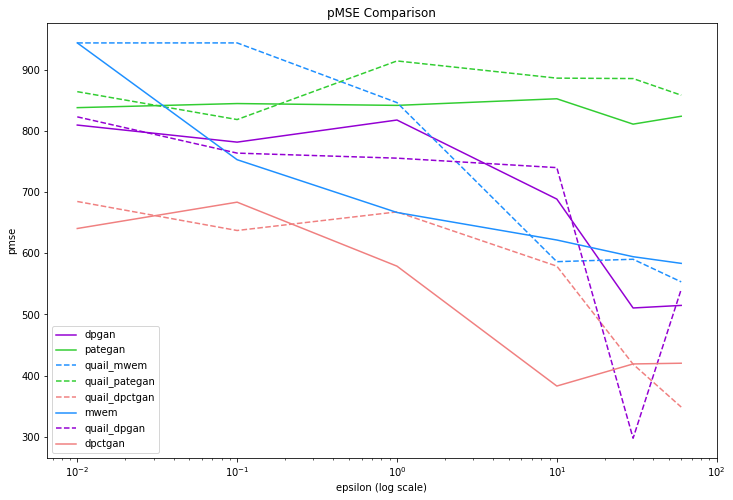

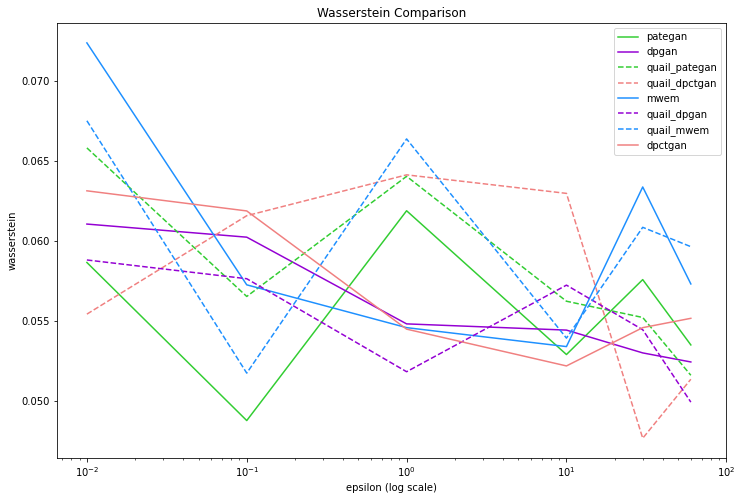

<Figure size 432x288 with 0 Axes>

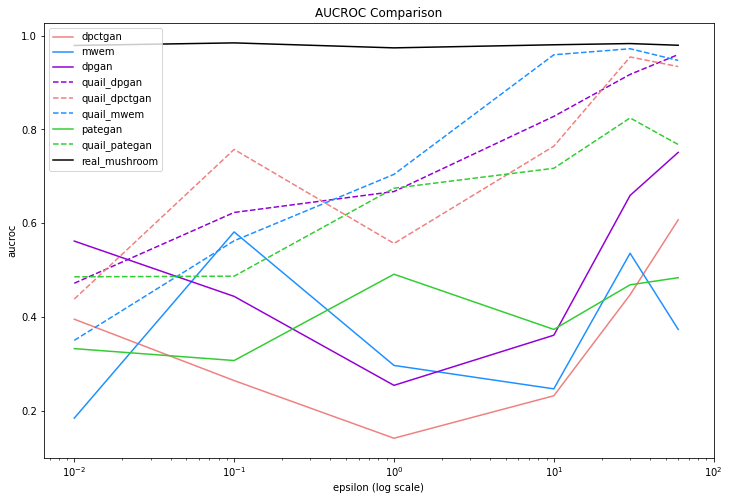

<Figure size 432x288 with 0 Axes>

In [63]:
for d in np.unique(runs['tags.dataset'].dropna()):
    make_plots(runs, 
               {"Synthesizer Comparison ML Classification": 
                {'x':'params.epsilon', 
                 'y':'metrics.max_accuracy', 
                 'series':'params.synthesizer', 
                 'dataset':'tags.dataset',
                 'x_label': "epsilon (log scale)", 
                 'y_label': "accuracy"},
                "pMSE Comparison": 
                {'x':'params.pmse_epsilon', 
                 'y':'metrics.pmse_score', 
                 'series':'params.pmse_synthesizer', 
                 'dataset':'tags.pmse_dataset',
                 'x_label': "epsilon (log scale)", 
                 'y_label': "pmse"},
                "Wasserstein Comparison": 
                {'x':'params.wasserstein_epsilon', 
                 'y':'metrics.wasserstein_score', 
                 'series':'params.wasserstein_synthesizer', 
                 'dataset':'tags.wasserstein_dataset',
                 'x_label': "epsilon (log scale)", 
                 'y_label': "wasserstein"},
                "AUCROC Comparison": 
                {'x':'params.aucroc_epsilon', 
                 'y':'metrics.aucroc', 
                 'series':'params.aucroc_synthesizer', 
                 'dataset':'tags.dataset',
                 'x_label': "epsilon (log scale)", 
                 'y_label': "aucroc"}
               })